In [2]:
#importazione librerie
from igraph import Graph
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [3]:
nodes=pd.read_csv('Nodes_df6.csv')
edges=pd.read_csv('Edges_df6.csv')

#### Individuiamo il Giant Component

In [4]:
#creazione grafo networkx
g_nx=nx.from_pandas_edgelist(edges,source='Source',target='Target')
component_subgraph_list = list(nx.connected_components(g_nx))
largest_component = list(max(component_subgraph_list,key=len))


In [5]:
#creazione grafo largest component con igraph
nodes_list=list(nodes.Id)
new_edges=edges[(edges['Source'].isin(largest_component)) & (edges['Target'].isin(largest_component))]
new_g=Graph.DataFrame(edges=new_edges[['Source','Target']],directed=True)

In [5]:
#creazione campo per individuare il giant component su gephi
nodes['Giant_Component']=0

colour=[]
for index in largest_component:
    subset=nodes[nodes.Id==index]
    if subset.empty == False:
        sub_index=subset.index
        nodes.at[sub_index,'Giant_Component']=1
    else:
        continue

#### Applichiamo leading eigenvector

In [6]:
#applichiamo
eigen=new_g.community_leading_eigenvector(2)
eigen.summary()

C:\Users\Eric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\igraph\__init__.py:1281: RuntimeWarning: This method was developed for undirected graphs at src/community/leading_eigenvector.c:530
  membership, _, q = GraphBase.community_leading_eigenvector(


'Clustering with 5190 elements and 2 clusters'

In [7]:
eigen_nodes=eigen.graph.vs["name"]
df_eigen=pd.DataFrame({'nodes':eigen_nodes,'clusters':eigen._membership})

<AxesSubplot:>

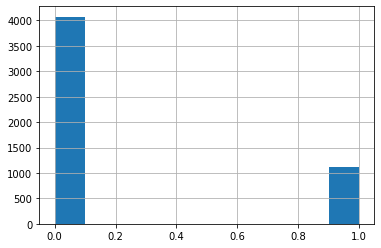

In [8]:
df_eigen["clusters"].hist()

In [9]:
df_eigen.groupby("clusters")["clusters"].count()

clusters
0    4073
1    1117
Name: clusters, dtype: int64

In [10]:
#definiamo una funzione che ci consenta di aggiungere al dataframe di partenza una nuova colonna con i cluster creati dall'algoritmo usato
def color_clusters(cluster_df,cluster_field,new_cluster_field_name):
    clusters=list(set(cluster_df[cluster_field]))
    nodes[new_cluster_field_name]=0

    for index, row in cluster_df.iterrows():
        subset=nodes[nodes.Id==int(row['nodes'])]
        if subset.empty == False:
            sub_index=subset.index
            for cluster in clusters:
                if row['clusters']==cluster:
                    nodes.at[sub_index,new_cluster_field_name]=cluster+1
        else:
            continue

In [11]:
color_clusters(df_eigen,'clusters','cluster_eigen')

#### Creazione indice e applicazione k-means

In [12]:
#creiamo un dizionario che trovi per ciascun nodo, i suoi nodi contigui. Ci servirà per applicare la Jaccard Similarity
contiguous_nodes_dict={}

for node in nodes.Id:
    lista_target=list(new_edges[new_edges.Source==node]['Target'])
    lista_source=list(new_edges[new_edges.Target==node]['Source'])
    lista_tot=lista_target+lista_source
    if lista_tot != []:
        contiguous_nodes_dict[node]=lista_tot

In [13]:
#creiamo un grafo networkx a partire dagli archi del giant component
G_directed=nx.from_pandas_edgelist(new_edges,source='Source',target='Target',create_using=nx.DiGraph())

In [17]:
#sfruttiamo la funzione networkx per costruire la matrice di adiecenza
adj=nx.adjacency_matrix(G_directed)

In [20]:
#applichiamo kmean alla matrice di adiacenza: osservando i risultati risulta performare meglio questa versione
kmeans2 = KMeans(n_clusters=2, random_state=0,n_init=100,max_iter=1000).fit(adj)

In [21]:
kmeans2=pd.DataFrame({"gruppo":kmeans2.labels_})

array([[<AxesSubplot:title={'center':'gruppo'}>]], dtype=object)

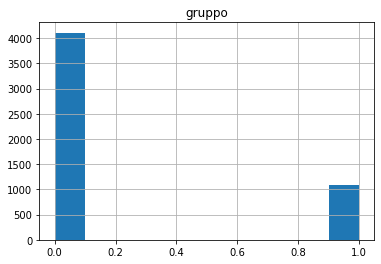

In [24]:
pd.DataFrame(kmeans2.gruppo).hist()

In [25]:
kmeans2.groupby("gruppo")["gruppo"].count()

gruppo
0    4110
1    1080
Name: gruppo, dtype: int64

In [26]:
df_means=pd.DataFrame({'nodes':contiguous_nodes_dict.keys(),'clusters':kmeans2.labels_})

In [27]:
color_clusters(df_means,'clusters','cluster_kmeans')

#### Girvan-Newman

In [6]:
new_G = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [new_g.vs['name']] 
                      for x in new_g.get_edgelist()], nx.DiGraph())

In [10]:
new_G=new_G.to_undirected()

In [7]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  #estrae l'arco con massimo score sulla betweenness centrality
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [8]:
def girvan_newman(graph):
	#trova il numero di componenti connessi
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [11]:
c = girvan_newman(new_G.copy())

#estrae i nodi appartenenti alle communities creando una lista di liste
node_groups = []

for i in c:
  node_groups.append(list(i))

In [40]:
#aggiorniamo la colonna corrispondente all'algoritmo con il risulatato della clusterizzazione
nodes['Colour_GN']=0

for group in range(0,len(node_groups)):
    for idx in node_groups[group]:
        subset=nodes[nodes.Id==int(idx)]
        if subset.empty == False:
            sub_index=subset.index
            nodes.at[sub_index,'Colour_GN']=group+1
        else:
            continue

(array([3176.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2014.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

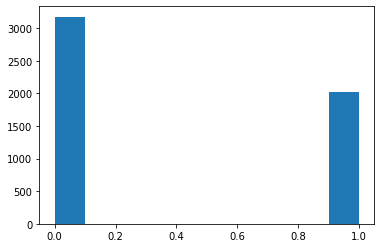

In [57]:
import matplotlib.pyplot as plt
gn_list=list(filter((0).__ne__, nodes['Colour_GN']))
plt.hist([0 if x==1 else 1 for x in gn_list])

In [58]:
from collections import Counter
count=Counter([0 if x==1 else 1 for x in gn_list])
for key, value in count.items():
    print(key,value)

0 3176
1 2014


##### Models Performance

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

In [78]:
#definiamo una classe per la valutazione delle performance che possa ritornare le statistiche e la confusion matrix
class Evaluations:

    def __init__(self, df, clusters_col_name):
        self.df=df
        self.clusters_col_name=clusters_col_name

    def conf_matrix(self):
        conf_mat=confusion_matrix(list(self.df.Colour), list(self.df[self.clusters_col_name]))
        df_conf_norm = pd.DataFrame(conf_mat)
        df_conf_norm_r=pd.DataFrame(conf_mat/np.array( [conf_mat.sum(axis=1),conf_mat.sum(axis=1)]).T)
        plt.matshow(df_conf_norm_r, cmap='Reds')
        plt.colorbar()

        for (i, j), z in np.ndenumerate(df_conf_norm.to_numpy()):
            plt.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')

        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.show()

    def metric(self):
        m=metrics.classification_report(list(self.df.Colour), list(self.df[self.clusters_col_name]), digits=3)
        print(m)

##### Eigen Evaluation

In [59]:
mapping={'#007474':2, '#042069':1, '#99cccc':1, '#b00b69':2, '#fb1239':1}

In [61]:
#attribuisco ai colori dei tag i gruppi numerati
nodes_pf=nodes.replace({'Colour':mapping})

In [68]:
#rimozione dei nodi non appartenenti al giant component prima di effettuare la valutazione delle performance
nodes_pf=nodes_pf[nodes_pf.Giant_Component==1]

In [76]:
print(Counter(nodes_pf.Colour))
print(Counter(nodes_pf.Colour_GN))

Counter({1: 3010, 2: 2180})
Counter({1: 3176, 2: 2014})


In [80]:
#si esplicita solo la valutazione migliore
eval_kmeans=Evaluations(nodes_pf,"Colour_GN")
eval_kmeans.metric()

              precision    recall  f1-score   support

           1      0.911     0.961     0.935      3010
           2      0.941     0.870     0.904      2180

    accuracy                          0.923      5190
   macro avg      0.926     0.915     0.920      5190
weighted avg      0.924     0.923     0.922      5190



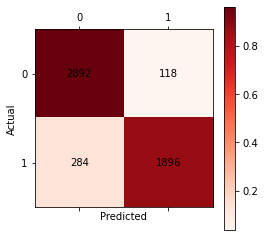

In [81]:
eval_kmeans.conf_matrix()